In [22]:
import os

import numpy as np
import scipy.optimize as sco
import scipy.special as scp
import scipy.integrate as sci

import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Declare functions for root-finding

In [2]:
# Functions for integrating (cos x)^{+/-0.5}, (sin x)^{+/-0.5}

def integ_sqrt_cos(x):
    """ Returns the integral of sqrt(cos) on [0, x] using incomplete beta functions
    \int_0^x \sqrt{cos t} dt = 0.5 * \int_0^{(sinx)^2} u^(-0.5)*(1-u)^(-0.25)du"""
    a, b = 0.5, 0.75
    beta_ratio = scp.betainc(a, b, np.sin(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)
    

def integ_sqrt_sin(x):
    """ Return the integral of sqrt(sin) on [0, x] using incomplete beta function 
    \int_0^x \sqrt{sin t} dt = 0.5 * beta(0.5, 0.75) - 0.5 * \int_0^{(cos x)^2} u^(-0.5)*(1-u)^(-0.25)du"""
    a, b = 0.5, 0.75
    beta_ratio = 1 - scp.betainc(a, b, np.cos(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)

def integ_inv_sqrt_cos(x):
    """ Returns the integral of 1/sqrt(cos) on [0, x] using incomplete beta functions
    \int_0^x 1/\sqrt{cos t} dt = 0.5 * \int_0^{(sinx)^2} u^(-0.5)*(1-u)^(-0.75)du"""
    a, b = 0.5, 0.25
    beta_ratio = scp.betainc(a, b, np.sin(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)

def integ_inv_sqrt_sin(x):
    """ Return the integral of 1/sqrt(sin) on [0, x] using incomplete beta function 
    \int_0^x 1/\sqrt{sin t} dt = 0.5 * beta(0.5, 0.25) - 0.5 * \int_0^{(cos x)^2} u^(-0.5)*(1-u)^(-0.75)du"""
    a, b = 0.5, 0.25
    beta_ratio = 1 - scp.betainc(a, b, np.cos(x)**2)
    return 0.5 * beta_ratio * scp.beta(a, b)

def reduced_integ_sqrt_sin(x):
    """ Return 1/sqrt(sin(x)) times the integral of sqrt(sin) on [0, x] using incomplete beta function 
    which is equivalent to 2x/3 at x=0"""

    out_forSmall = 2 * x / 3.
    out_forLarge = integ_sqrt_sin(x) / np.sqrt(np.abs(np.sin(x)))
    
    return np.where(x < 1e-3, out_forSmall, out_forLarge)


### Version1 : Naive with sqrt(sin,cos,...)

In [ ]:
# Old code

def check_angles_float(alpha_1, alpha_2):
    if alpha_1 < 0.:
        print("Warning: alpha_1 < 0")
        alpha_1 = 0.
    if alpha_1 > np.pi/2.:
        print("Warning: alpha_1 > pi/2")
        alpha_1 = np.pi/2.
    if alpha_2 < 0.:
        print("Warning: alpha_2 < 0")
        alpha_2 = 0.
    if alpha_2 > np.pi/2.:
        print("Warning: alpha_2 > pi/2")
        alpha_2 = np.pi/2.
    if alpha_1 < alpha_2:
        print("Warning: alpha_1 < alpha_2")
        alpha_1, alpha_2 = np.mean(alpha_1, alpha_2), np.mean(alpha_1, alpha_2) 
    return alpha_1, alpha_2

def func_naiv_all(alpha_1, alpha_2, force, W, a, H):
    # Check that arguments are on correct set
    alpha_1, alpha_2 = check_angles_float(alpha_1, alpha_2)
    force = np.max([force, 0.])

    # Compute elliptic functions
    P_a1_a2 = integ_sqrt_sin(alpha_1 - alpha_2) 
    M_a2 = integ_sqrt_cos(alpha_2)

    # Right hand side equations
    eq1 = 2 * np.cos(alpha_1) * np.sqrt(np.sin(alpha_1-alpha_2)) + np.sin(alpha_1) * P_a1_a2
    eq2 = 2 * np.sin(alpha_1) * np.sqrt(np.sin(alpha_1-alpha_2)) - np.cos(alpha_1) * P_a1_a2
    eq3 = np.sqrt(np.cos(alpha_2) / np.sin(alpha_1 - alpha_2)) * M_a2

    prefac = np.sqrt(2 * force)

    return np.array([eq1 - prefac * W, 
                     eq2 - prefac * H, 
                     eq3 - prefac * a])

def jac_naiv_all(alpha_1, alpha_2, force, W, a, H):
    #TODO
    dfact1_d1 = 0.5 * np.cos(alpha_1 - alpha_2) * np.cos(alpha_1) / np.sqrt(np.sin(alpha_1 - alpha_2)) - np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact3_d1 = 0.5 * np.cos(alpha_1 - alpha_2) * np.sin(alpha_1) / np.sqrt(np.sin(alpha_1 - alpha_2)) + np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact1_d2 = - 0.5 * np.cos(alpha_1) * np.cos(alpha_1 - alpha_2) / np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact3_d2 = - 0.5 * np.sin(alpha_1) * np.cos(alpha_1 - alpha_2) / np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact2_d1 = np.cos(alpha_1) * integ_sqrt_sin(alpha_1 - alpha_2) + np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact2_d2 = - np.sin(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact4_d1 = np.sin(alpha_1) * integ_sqrt_sin(alpha_1 - alpha_2) - np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))
    dfact4_d2 = np.cos(alpha_1) * np.sqrt(np.sin(alpha_1 - alpha_2))

    dfact5_d1 = - np.cos(alpha_1 - alpha_2) / np.sin(alpha_1 - alpha_2) * np.sqrt(np.cos(alpha_2) / np.sin(alpha_1 - alpha_2)) * integ_sqrt_cos(alpha_2)

    return 0.

### Version 2: Improve system to remove sqrt(sin)

In [ ]:
# Code 22/01/2024

def check_angles(alpha1, alpha2):
    # Take max(0, alpha)
    alpha1 = (alpha1 + np.abs(alpha1)) / 2.
    alpha2 = (alpha2 + np.abs(alpha2)) / 2.

    # Take min(pi/2, alpha)
    alpha1 = np.pi/2 - ((np.pi/2. - alpha1) + np.abs(np.pi/2. - alpha1)) / 2.
    alpha2 = np.pi/2 - ((np.pi/2. - alpha2) + np.abs(np.pi/2. - alpha2)) / 2.

    # Take alpha2 = min(alpha2, alpha1)
    alpha2 = alpha1 - ((alpha1 - alpha2) + np.abs(alpha1 - alpha2)) / 2.

    return alpha1, alpha2

def func_all(alpha1, alpha2, force, W, H, a):
    # Check that arguments are on correct set (alpha in [0, pi/2], force>0)
    alpha1, alpha2 = check_angles(alpha1, alpha2)
    force = (force + np.abs(force)) / 2.

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Functions to find roots
    eq1 = force * (W * np.cos(alpha1) + H * np.sin(alpha1))**2 - 2 * np.sin(alpha1 - alpha2)
    eq2 = 2 * force * (W * np.sin(alpha1) - H * np.cos(alpha1))**2 - P_a1_a2**2
    eq3 = np.cos(alpha2) * M_a2**2 - 2 * force * a**2 * np.sin(alpha1 - alpha2)

    return np.array([eq1, eq2, eq3])

def jac_all(alpha1, alpha2, force, W, H, a):
    # Check that arguments are on correct set (alpha in [0, pi/2], force>0)
    alpha1, alpha2 = check_angles(alpha1, alpha2)
    force = (force + np.abs(force)) / 2.

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Shortcuts
    cos1, sin1 = np.cos(alpha1), np.sin(alpha1)
    cos2, sin2 = np.cos(alpha2), np.sin(alpha2)
    cos12, sin12 = np.cos(alpha1 - alpha2), np.sin(alpha1 - alpha2)

    # Derivatives
    deq1_da1 = 2 * force * (H * cos1 - W * sin1) * (W * cos1 + H * sin1) - 2 * cos12
    deq1_da2 = 2 * cos12
    deq1_df = (W * cos1 + H * sin1)**2

    deq2_da1 = 4 * force * (W * cos1 + H * sin1) * (W * sin1 - H * cos1) - 2 * P_a1_a2 * np.sqrt(sin12)
    deq2_da2 = - 2 * P_a1_a2 * np.sqrt(sin12)
    deq2_df = 2 * (W * sin1 - H * cos1)**2

    deq3_da1 = - 2 * force * a**2 * cos12
    deq3_da2 = - sin2 - M_a2**2 + 2 * cos2 * M_a2 * np.sqrt(cos2) + 2 * force * a**2 * cos12
    deq3_df = - 2 * a**2 * sin12

    return np.array([[deq1_da1, deq1_da2, deq1_df], 
                     [deq2_da1, deq2_da2, deq2_df],
                     [deq3_da1, deq3_da2, deq3_df]])


def s1_s2_from_alpha_f(alpha1, alpha2, force, L):

    s2_s1 = 1. / np.sqrt(2 * force) * integ_inv_sqrt_sin(alpha1 - alpha2)
    L_s2 = 1. / np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2)) * integ_inv_sqrt_cos(alpha2)
    print(L_s2)

    s2 = L - L_s2
    s1 = s2 - s2_s1

    return s1, s2

def solve_from_all_param(s1, s2, L, alpha1, alpha2, force, nbPoints=50):
    def func_2(s, y):
        return np.array([y[1], 
                         -force * np.cos(y[0] - alpha1)])
    def func_3(s, y):
        return np.array([y[1], 
                         -force * np.sin(alpha1-alpha2) / np.cos(alpha2) * np.sin(y[0])])
    
    t_eval_1 = np.linspace(0, s1, nbPoints)
    
    t_span_2 = [s1, s2]
    y0_2 = np.array([alpha1, 0])
    t_eval_2 = np.linspace(*t_span_2, nbPoints)

    t_span_3 = [s2, L]
    y0_3 = np.array([alpha2, - np.sqrt(2*force * np.sin(alpha1-alpha2))])
    t_eval_3 = np.linspace(*t_span_3, nbPoints)

    sol_1 = np.full_like(t_eval_1, alpha1)
    sol_2 = sci.solve_ivp(func_2, t_span_2, y0_2, t_eval_2)
    sol_3 = sci.solve_ivp(func_3, t_span_3, y0_3, t_eval_3)

    return (np.concatenate((t_eval_1, sol_2.t, sol_3.t)), 
            np.concatenate((sol_1, sol_2.y, sol_3.y)))



### Version 3 : similar as V2, but one equation is not squared anymore

In [ ]:
# Code 23/01/2024 -> from notes

HUGE = 1e16

def check_arguments(alpha1, alpha2, force):
    isTooSmall = ((alpha1 < 0) | (alpha2 <0))
    isTooLarge = ((alpha1 > np.pi/2) | (alpha2 > np.pi/2))
    isWrongOrder = (alpha1 < alpha2)

    isForceNeg = (force < 0)
    
    return ~(isTooLarge | isTooSmall | isWrongOrder | isForceNeg)

def func_root_all(alpha1, alpha2, force, W, H, a):
    # Check is arguments correct
    args_correct = check_arguments(alpha1, alpha2, force)

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2 = integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Writes shortcuts
    sin1, cos1 = np.sin(alpha1), np.cos(alpha1)
    sin12 = np.sin(alpha1 - alpha2)
    cos2 = np.cos(alpha2)

    # Compute functions to find roots of
    eq1 = force * (cos1 * W + sin1 * H)**2 - 2 * sin12
    eq2 = np.sqrt(2 * np.abs(force)) * (sin1 * W - cos1 * H) - P_a1_a2
    eq3 = 2 * force * sin12 * a**2 - cos2 * M_a2**2

    equations = np.array([eq1, eq2, eq3])
    equations[:,~args_correct] = HUGE

    return equations

def s1_s2_from_param(alpha1, alpha2, force, L):
    assert check_arguments(alpha1, alpha2, force), f'Solution is not between bounds: {alpha1, alpha2, force}'

    s2_s1 = 1. / np.sqrt(2 * force) * integ_inv_sqrt_sin(alpha1 - alpha2)
    L_s2 = 1. / np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2)) * integ_inv_sqrt_cos(alpha2)

    s2 = L - L_s2
    s1 = s2 - s2_s1
    return s1, s2

def solve_alpha_from_all_param(s1, s2, L, alpha1, alpha2, force, nbPoints=50):
    def reg2(s, alpha):
        return - np.sqrt(2 * force * np.sin(alpha1 - alpha))
    
    def reg3(s, alpha):
        return - np.sqrt(2 * force * np.sin(alpha1-alpha2)/np.cos(alpha2) * np.cos(alpha))
    
    t_eval_1 = np.linspace(0, s1, nbPoints, endpoint=False)

    t_span_2 = [s1, s2]
    t_eval_2 = np.linspace(*t_span_2, nbPoints, endpoint=False)
    y0_2 = np.array([alpha1])

    t_span_3 = [s2, L]
    t_eval_3 = np.linspace(s2, L, nbPoints)
    y0_3 = np.array([alpha2])

    sol_1 = np.full_like(t_eval_1, alpha1)
    sol_2 = sci.solve_ivp(reg2, t_span_2, y0_2, t_eval=t_eval_2)
    sol_3 = sci.solve_ivp(reg3, t_span_3, y0_3, t_eval=t_eval_3)

    return (np.concatenate((t_eval_1, sol_2.t, sol_3.t)), 
            np.concatenate((sol_1, sol_2.y.flatten(), sol_3.y.flatten())))

In [ ]:
# Test function

W, H, a = 4e-2, 5e-5, 1e-2

alpha1 = np.array([0, -1, 0.2, 0.2, np.pi, 0.5, 0.4])
alpha2 = np.array([0.1, 0.2, 0.1, 0.3, 0.1, 0.1, 0.05])
force = np.array([1,1,1,1,1,-2, 5])

print(check_arguments(alpha1, alpha2, force))
print(func_root_all(alpha1, alpha2, force, W, H, a))

In [ ]:
# Plot function to find zero

W, H, a = 1e-1, 5e-2, 2e-2

alpha1_ = np.linspace(0, np.pi/2., 100)
alpha2_ = np.linspace(0, np.pi/2., 100)
force_ = 2.

alpha1, alpha2 = np.meshgrid(alpha1_, alpha2_)
force = np.full_like(alpha1, force_)

eq1, eq2, eq3 = func_all(alpha1, alpha2, force, W, H, a)
jac = jac_all(alpha1, alpha2, force, W, H, a)

print(jac.shape)

# Parameters plot
levels=100

fig, ax = plt.subplots(figsize=(15,5), ncols=3)

ax[0].contourf(alpha1, alpha2, eq1, levels=levels)
ax[1].contourf(alpha1, alpha2, eq2, levels=levels)
ax[2].contourf(alpha1, alpha2, eq3, levels=levels)

alpha1_quiv = alpha1[::5,::5]
alpha2_quiv = alpha2[::5,::5]
jac_quiv = jac[:,:,::5,::5]

ax[0].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[0,0], jac_quiv[0,1], color='k', angles='xy')
ax[1].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[1,0], jac_quiv[1,1], color='k', angles='xy')
ax[2].quiver(alpha1_quiv, alpha2_quiv, jac_quiv[2,0], jac_quiv[2,1], color='k', angles='xy')

for axi in ax:
    axi.set_aspect(1)
    axi.set_xlabel('Alpha 1')
    axi.set_ylabel('Alpha 2')

plt.show()

### Version 4: no force in system

Express the force as a function of $(\alpha_1, \alpha_2)$ in order to have a system of two unknown instead of 3

\begin{equation}
    \left\{
    \begin{aligned}
        & 2 \left( W \sin(\alpha_1) - H \cos(\alpha_1) \right) = \left( W \cos(\alpha_1) + H \sin(\alpha_1) \right) \frac{1}{\sqrt{\sin(\alpha_1 - \alpha_2)}} \int_0^{\alpha_1 - \alpha_2} \sqrt{\sin(\phi)} d\phi \\
        & 4 \sin^2(\alpha_1 - \alpha_2) a^2 = \left( W \cos(\alpha_1) + H \sin(\alpha_1) \right)^2 \cos(\alpha_2) \left( \int_0^{\alpha_2} \sqrt{\cos(\phi)} d\phi \right)^2 \\
        & f_1 = \frac{2 \sin(\alpha_1 - \alpha_2)}{\left( W \cos(\alpha_1) + H \sin(\alpha_1) \right)^2}
    \end{aligned}
    \right.
\end{equation}

In [39]:
# Code 24/01/2023

HUGE = 1e16
SMALL = 1e-16

def check_angles(alpha1, alpha2):
    isTooSmall = ((alpha1 < 0) | (alpha2 <0))
    isTooLarge = ((alpha1 > np.pi/2) | (alpha2 > np.pi/2))
    isWrongOrder = (alpha1 < alpha2)
    
    return ~(isTooLarge | isTooSmall | isWrongOrder)

def func_root_all(alpha1, alpha2, W, H, a):
    # Check is arguments correct
    angles_correct = check_angles(alpha1, alpha2)

    # Compute primitives sqrt(cos), sqrt(sin)
    P_a1_a2_red = reduced_integ_sqrt_sin(alpha1 - alpha2)
    M_a2 = integ_sqrt_cos(alpha2)

    # Writes shortcuts
    sin1, cos1 = np.sin(alpha1), np.cos(alpha1)
    sin12 = np.sin(alpha1 - alpha2)
    cos2 = np.cos(alpha2)

    # Compute functions to find roots of
    eq1 = 2 * (W*sin1 - H*cos1) - (W*cos1 + H*sin1) * P_a1_a2_red
    eq2 = 4 * sin12**2 * a**2 - (W*cos1 + H*sin1)**2 * cos2 * M_a2**2 

    equations = np.array([eq1, eq2])
    equations[:, ~angles_correct] = HUGE

    return equations

def force_from_angles(alpha1, alpha2):
    assert np.all(check_angles(alpha1, alpha2)), f'Solution is not between bounds: {alpha1, alpha2}'
    force = 2 * np.sin(alpha1 - alpha2) / (W * np.cos(alpha1) + H * np.sin(alpha1))**2
    return force

def l2_l3_force_from_angles(alpha1, alpha2, force=None):
    if force is None:
        force = force_from_angles(alpha1, alpha2)
    
    l2 = 1. / np.sqrt(2 * force) * integ_inv_sqrt_sin(alpha1 - alpha2)
    l3 = 1. / np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2)) * integ_inv_sqrt_cos(alpha2)

    return l2, l3, force
    
def solve_alpha_from_all_param(l2, l3, alpha1, alpha2, force, nbPoints=50):
    """ Solves the first integral of movement, starting from S=L (middle)
    """
    def reg2(sInv, alpha):
        return np.sqrt(2 * force * np.sin(alpha1 - alpha))
    
    def reg3(sInv, alpha):
        return np.sqrt(2 * force * np.sin(alpha1-alpha2)/np.cos(alpha2) * np.cos(alpha))

    # Solve pb in region 3
    sInv_span_3 = [0, l3]
    sInv_eval_3 = np.linspace(*sInv_span_3, nbPoints, endpoint=False)
    alpha0_3 = np.array([0])

    sol_3 = sci.solve_ivp(reg3, sInv_span_3, alpha0_3, t_eval=sInv_eval_3)

    # Solve pb in region 2
    sInv_span_2 = [l3, l3+l2]
    sInv_eval_2 = np.linspace(*sInv_span_2, 2*nbPoints)
    alpha0_2 = np.array([alpha2])

    sol_2 = sci.solve_ivp(reg2, sInv_span_2, alpha0_2, t_eval=sInv_eval_2)


    # Concatenate solution
    sInv = np.concatenate((sol_3.t, sol_2.t))
    alpha = np.concatenate((sol_3.y.flatten(), sol_2.y.flatten()))

    # Convert back the curvilinear coordinate and reverse the angle array
    s = l2 + l3 - sInv[::-1]
    alpha = alpha[::-1]

    return s, alpha

def xy_from_alpha_s(s, alpha):
    # Using rectangle rule
    x = [0]
    y = [0]

    ds = np.diff(s)
    for i in range(len(s)-1):
        x.append(x[-1] + ds[i] * np.cos(alpha[i]))
        y.append(y[-1] + ds[i] * np.sin(alpha[i]))
    
    return np.array(x), np.array(y)

In [19]:
class ZeroCenteredNorm():

    def __init__(self, vmin, vmax):
        assert vmin < vmax

        SMALL = 1e-6
        if vmin >= 0:
            vmin = -SMALL
        if vmax <= 0:
            vmax = SMALL

        self.vmin = vmin
        self.vmax = vmax

        def norm_(x):
            if x < vmin:
                return 0
            if x > vmax:
                return 1
            if x < 0:
                return -0.5 * (x - vmin) / vmin
            if x >=0:
                return 1. + 0.5 * (x - vmax) / vmax
            else:
                print('Oups, issue')
                return None
        
        self.norm_ = norm_
    
    def __call__(self, value, clip=None):
        return np.fromiter((self.norm_(xi) for xi in value), value.dtype)
    
    def autoscale_None(A, _):
        return 
    
    

c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


0.015866629563584814 0.015866629563584714


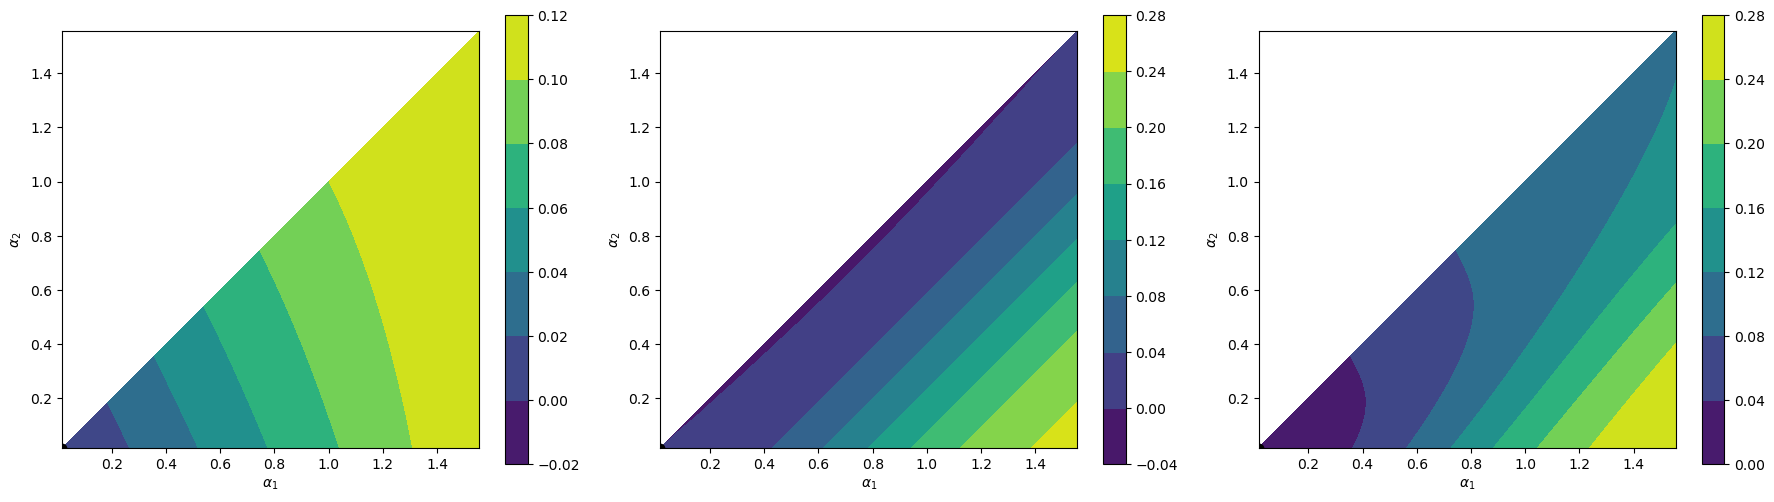

In [33]:
# Plot function to find roots of

W, H, a = 6e-2, 0.1e-2, 25e-2

alpha1_ = np.linspace(0, np.pi/2., 100)[1:-1]
alpha2_ = np.linspace(0, np.pi/2., 100)[1:-1]

# Create mesh
alpha1, alpha2 = np.meshgrid(alpha1_, alpha2_)

# Remove alpha1 < alpha2
wrongAngles = (alpha1 <= alpha2)
alpha2 = np.where(wrongAngles, alpha1-SMALL, alpha2)

# Compute functions
eq1, eq2 = func_root_all(alpha1, alpha2, W, H, a)

# Find min value
total_cost = np.sqrt(eq1**2 + eq2**2)
argmin = np.argmin(total_cost)
alpha1_guess, alpha2_guess = alpha1.flatten()[argmin], alpha2.flatten()[argmin]
print(alpha1_guess, alpha2_guess)

# Plot
fig, ax = plt.subplots(figsize=(18,5), ncols=3, tight_layout=True)

cont0 = ax[0].contourf(alpha1, alpha2, eq1)
cont1 = ax[1].contourf(alpha1, alpha2, eq2)
cont2 = ax[2].contourf(alpha1, alpha2, total_cost)

fig.colorbar(cont0, ax=ax[0])
fig.colorbar(cont1, ax=ax[1])
fig.colorbar(cont2, ax=ax[2])

for axi in ax:
    axi.plot(alpha1_guess, alpha2_guess, 'ko')
    axi.set_xlabel("$\\alpha_1$")
    axi.set_ylabel("$\\alpha_2$")
    axi.set_aspect(1)

plt.show()


## Test full computation

In [94]:
W, H, a = 6e-2, 10e-2, 2.5e-2

func = (lambda guess: func_root_all(guess[0], guess[1], W, H, a))

c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


1.3486635129047093 0.3966657390896204


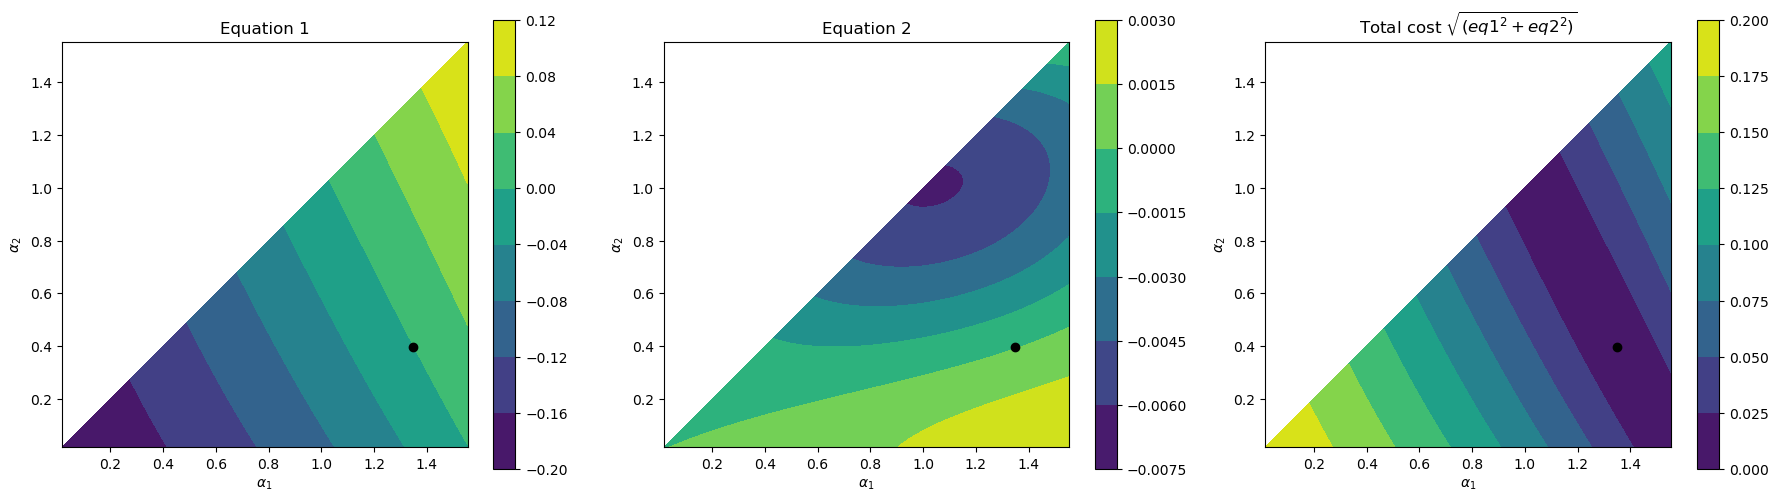

In [95]:
# Plot to check

alpha1_ = np.linspace(0, np.pi/2., 100)[1:-1]
alpha2_ = np.linspace(0, np.pi/2., 100)[1:-1]

# Create mesh
alpha1, alpha2 = np.meshgrid(alpha1_, alpha2_)

# Remove alpha1 < alpha2
wrongAngles = (alpha1 <= alpha2)
alpha2 = np.where(wrongAngles, alpha1-SMALL, alpha2)

# Compute functions
eq1, eq2 = func([alpha1, alpha2])

# Find min value
total_cost = np.sqrt(eq1**2 + eq2**2)
argmin = np.argmin(total_cost)
alpha1_guess, alpha2_guess = alpha1.flatten()[argmin], alpha2.flatten()[argmin]
print(alpha1_guess, alpha2_guess)

# Plot
fig, ax = plt.subplots(figsize=(18,5), ncols=3, tight_layout=True)

cont0 = ax[0].contourf(alpha1, alpha2, eq1)
cont1 = ax[1].contourf(alpha1, alpha2, eq2)
cont2 = ax[2].contourf(alpha1, alpha2, total_cost)

fig.colorbar(cont0, ax=ax[0])
fig.colorbar(cont1, ax=ax[1])
fig.colorbar(cont2, ax=ax[2])

ax[0].set_title('Equation 1')
ax[1].set_title('Equation 2')
ax[2].set_title('Total cost $\sqrt{(eq1^2 + eq2^2)}$')

for axi in ax:
    axi.plot(alpha1_guess, alpha2_guess, 'ko')
    axi.set_xlabel("$\\alpha_1$")
    axi.set_ylabel("$\\alpha_2$")
    axi.set_aspect(1)

plt.show()


In [96]:
# Sample to gess

nbSample = 100
alpha1_ = np.linspace(0, np.pi/2., nbSample+2)[1:-1]
alpha2_ = np.linspace(0, np.pi/2., nbSample+2)[1:-1]

# Create mesh
alpha1, alpha2 = np.meshgrid(alpha1_, alpha2_)

# Remove alpha1 < alpha2
wrongAngles = (alpha1 <= alpha2)
alpha2 = np.where(wrongAngles, alpha1-SMALL, alpha2)

# Compute functions
eq1, eq2 = func([alpha1, alpha2])

# Find min value
total_cost = np.sqrt(eq1**2 + eq2**2)
argmin = np.argmin(total_cost)
alpha1_guess, alpha2_guess = alpha1.flatten()[argmin], alpha2.flatten()[argmin]

print(f"Guess: alpha1 = {alpha1_guess:.2f}, alpha2 = {alpha2_guess:.2f}")

Guess: alpha1 = 1.35, alpha2 = 0.39


c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [97]:
x0 = np.array([alpha1_guess, alpha2_guess])

sol = sco.root(func, x0)
sol

    fjac: array([[-0.99976681, -0.02159445],
       [ 0.02159445, -0.99976681]])
     fun: array([-1.91929805e-14, -5.05845366e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-6.68380696e-11, -1.92426491e-11])
       r: array([-0.16146148, -0.08449652,  0.01185487])
  status: 1
 success: True
       x: array([1.35488967, 0.39138509])

In [98]:
# Compute solution

alpha1, alpha2 = sol.x

l2, l3, force = l2_l3_force_from_angles(alpha1, alpha2)
print(f"L2: {l2:.2e}")
print(f"L3: {l3:.2e}")

# Integrate solution and compute curvature and strain
s, alpha = solve_alpha_from_all_param(l2, l3, alpha1, alpha2, force)
curvature = np.gradient(alpha, s)
x, y = xy_from_alpha_s(s, alpha)
strain = np.log(np.cos(alpha))

# Change x origin to be in the middle
x = x - (W+a)


L2: 1.22e-01
L3: 2.57e-02


c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt


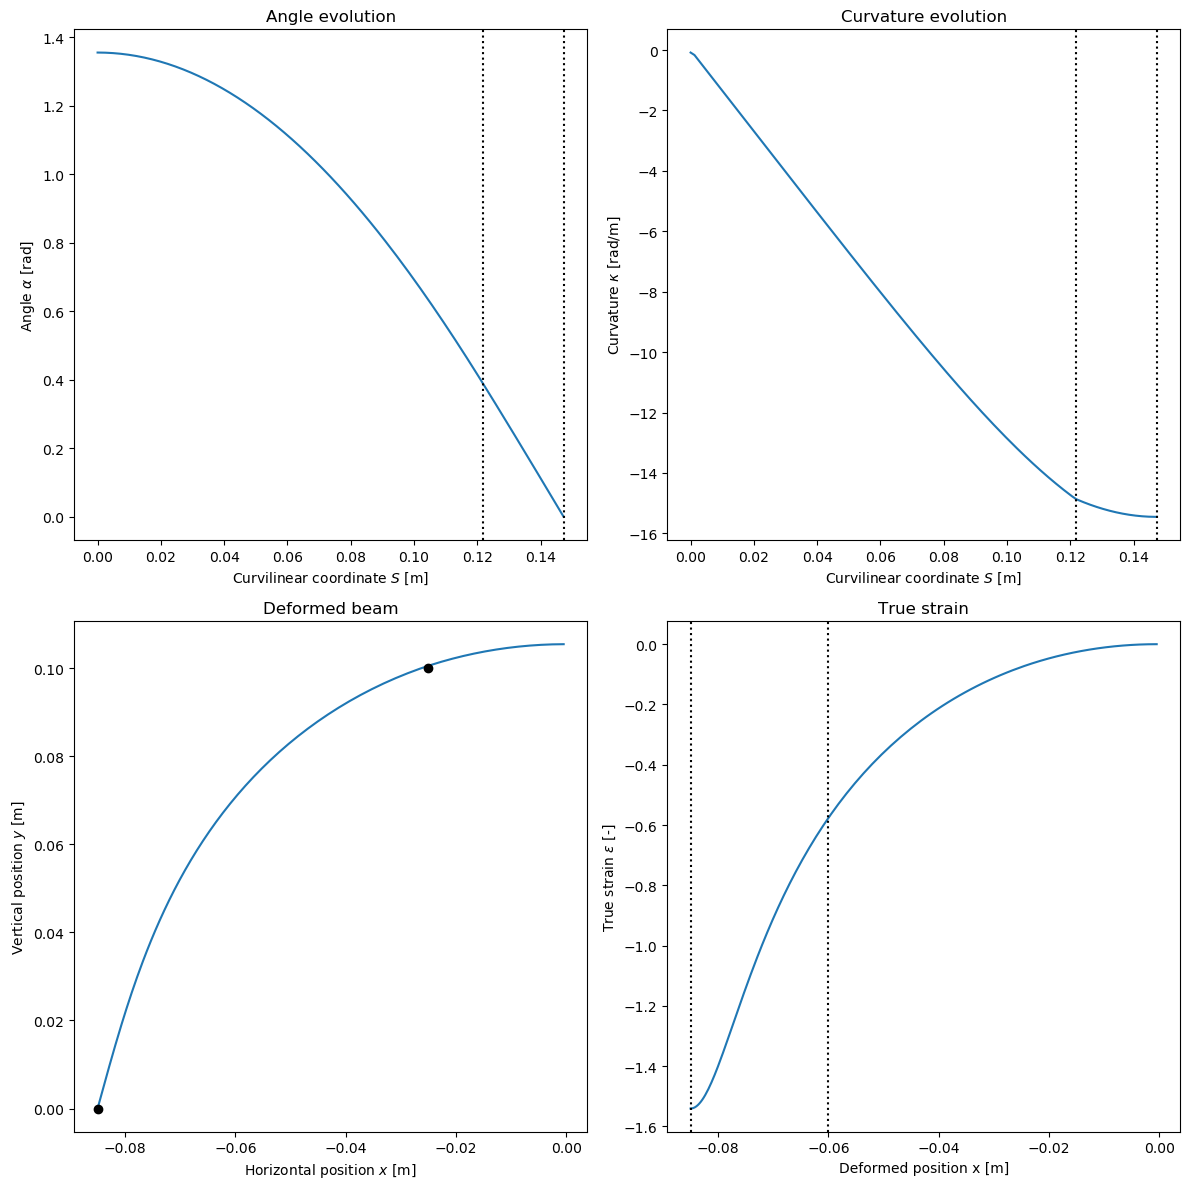

In [99]:
# Plot solution and strain

save = False
savepath = "/home/anais/Desktop/Alexandre/figures/4-points_flexion/W_60mm_H_50mm_a_25mm.png"

fig, ax = plt.subplots(figsize=(12,12), ncols=2, nrows=2, tight_layout=True)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
#fig.suptitle(f"Beam deformation for (W,a,H)=({100*W:.1f}cm, {100*a:.1f}cm, {100*H:.1f}cm)")

# Plot angle evolution
ax[0,0].plot(s, alpha)
ax[0,0].axvline(l2, ls=':', c='k')
ax[0,0].axvline(l2+l3, ls=':', c='k')
ax[0,0].set_xlabel('Curvilinear coordinate $S$ [m]')
ax[0,0].set_ylabel('Angle $\\alpha$ [rad]')
ax[0,0].set_title('Angle evolution')

# Plot angle evolution
ax[0,1].plot(s, np.gradient(alpha, s))
ax[0,1].axvline(l2, ls=':', c='k')
ax[0,1].axvline(l2+l3, ls=':', c='k')
ax[0,1].set_xlabel('Curvilinear coordinate $S$ [m]')
ax[0,1].set_ylabel('Curvature $\\kappa$ [rad/m]')
ax[0,1].set_title('Curvature evolution')

# Plot (x,y) view
ax[1,0].plot(x, y)
ax[1,0].plot(-(W+a), 0, 'ko')
ax[1,0].plot(-a, H, 'ko')
ax[1,0].set_xlabel('Horizontal position $x$ [m]')
ax[1,0].set_ylabel('Vertical position $y$ [m]')
ax[1,0].set_title('Deformed beam')

# TODO: Add arrows for x,y plot
if False:
    arrow_style = {"head_starts_at_zero":True, "color":"k", 'shape':'full'}
    ax[2].arrow(-(W+a), 0, W, 0, **arrow_style)
    ax[2].arrow(-a, 0, a, 0, **arrow_style)
    ax[2].arrow(-a, 0, 0, H, **arrow_style)
    ax[2].annotate(f'W={100*W:.1f}cm', xy=(-a-W/2.,0), xytext=(0,5), textcoords='offset points')
    ax[2].annotate(f'a={100*a:.1f}cm', xy=(-a/2.,0), xytext=(0,5), textcoords='offset points')
    ax[2].annotate(f'H={100*H:.1f}cm', xy=(-a,H/2.), xytext=(5,0), textcoords='offset points')

# Plot strain as function of new x
ax[1,1].plot(x, strain)
ax[1,1].axvline(-W, ls=':', c='k')
ax[1,1].axvline(-(W+a), ls=':', c='k')
ax[1,1].set_xlabel('Deformed position x [m]')
ax[1,1].set_ylabel('True strain $\epsilon$ [-]')
ax[1,1].set_title('True strain')

if save:
    plt.savefig(savepath, dpi=400)

plt.show()


## Evolution of the central curvature as a function of H

In [118]:
# Define parameters

W, a = 6e-2, 2.5e-2
H_array = np.linspace(1e-4, 55e-3, 1000)

In [119]:
# Compute the curvature

k_min = np.empty_like(H_array)
k_max = np.empty_like(H_array)

alpha_guess = [1e-2, 1e-2]

for i in range(H_array.size):
    # Prepare guess and function
    H = H_array[i]
    x0 = np.array(alpha_guess)
    func = (lambda alpha: func_root_all(alpha[0], alpha[1], W, H, a))

    sol = sco.root(func, x0)
    
    if not sol.success:
        continue

    alpha1, alpha2 = sol.x
    force = force_from_angles(alpha1, alpha2)

    k_min[i] = np.sqrt(2 * force * np.sin(alpha1 - alpha2))
    k_max[i] = np.sqrt(2 * force * np.sin(alpha1 - alpha2) / np.cos(alpha2))

    alpha_guess = sol.x

c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


In [120]:
# Compute small deformation result

ratio = a / W
kappa_eps = 2 * H_array / W**2 * (0.75 + 4.5 * ratio**2 - 1.5 * ratio * np.sqrt(9 * ratio**2 + 3))

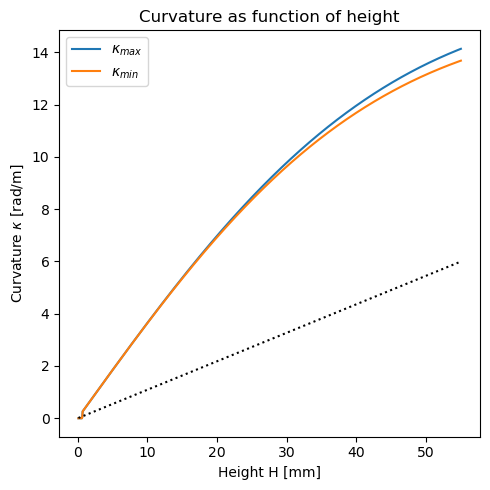

In [121]:
# Print evolution of curvature as function of H

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)

ax.plot(1e3 * H_array, k_max, label='$\\kappa_{max}$')
ax.plot(1e3 * H_array, k_min, label='$\\kappa_{min}$')
ax.plot(1e3 * H_array, kappa_eps, ls=':', c='k')

ax.set_xlabel('Height H [mm]')
ax.set_ylabel('Curvature $\\kappa$ [rad/m]')
ax.set_title('Curvature as function of height')

ax.legend()

plt.show()

## Compute visual strain

Let's list the transformations happening


* Due to the flexion of the plaque, a point $\vec X$ of curvilinear abscissa $S$ is moved at $\vec x$.
* Due to projection on a 2D plane (filming), the point $\vec x$ is moved at $\vec x^*$.

If there is no parallax effect, the projection onto the 2D plane is orthogonal and $\vec x$ and $\vec x^*$ have the same horizontal components. Thus, 

$$
\epsilon^* = \log\left(\frac{d x*}{d X}\right) = \log\left(\frac{d x}{d S}\right) = \log\left(\cos \alpha\right) \le 0
$$
where $X - X_0 = S - S_0$ because the reference position is horizontal.

In [78]:
W, a = 6e-2, 2.5e-2
H = 25e-3

func = (lambda alpha: func_root_all(alpha[0], alpha[1], W, H, a))

# Compute angles
x0 = np.array([1e-2, 1e-2])
sol = sco.root(func, x0)

alpha1, alpha2 = sol.x
print(f'Alpha1 = {alpha1:.1e}')
print(f'Alpha2 = {alpha2:.1e}')

# Compute lengths, force and solution
l2, l3, force = l2_l3_force_from_angles(alpha1, alpha2)
s, alpha = solve_alpha_from_all_param(l2, l3, alpha1, alpha2, force)

# Compute strain
strain = np.log(np.cos(alpha))


Alpha1 = 6.2e-01
Alpha2 = 1.0e-02


c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\alext.LAPTOP-8BUEPHEF\Anaconda3\envs\DIC\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
